# 패키지 불러오기

In [1]:
import math
import numpy as np
import pandas as pd
from IPython.core.interactiveshell import InteractiveShell
import matplotlib.pyplot as plt
import ksif
from ksif import Portfolio
InteractiveShell.ast_node_interactivity = "all"
%matplotlib inline
pd.set_option('display.max_columns', 500)
import sklearn
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy import stats
import statistics
import math

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
/Users/imchaebin/Library/Python/3.6/lib/python/site-packages/ksif/core/frame.py:23: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import MultiIndex


# 데이터 불러오기 (by ksif package)

In [2]:
pf = Portfolio()
pf = pf[pf['date'] > '2015-04-01']
kospi200 = pd.read_csv("./kospi200_investing.com.csv")
bok_standard_rate = pd.read_csv('./bok_standard_rate.csv')

In [3]:
kospi200 = kospi200.loc[::-1]
kospi200.reset_index(inplace = True)

In [4]:
kospi200['변동 %'] = kospi200['변동 %'].str.replace('%','')
kospi200['변동 %'] = pd.to_numeric(kospi200['변동 %'])
kospi200.loc[::-1].reset_index(drop = True, inplace = True)
kospi200['변동 %'] = kospi200['변동 %']/100

### a. 회사 선정
##### 주의. Market Index를 KOSPI200으로 하였으므로, 종목을 선정할 때 KOSPI200에 포함되는 종목을 추천함.

In [5]:
# 회사 고르기
name1 = '삼성전자'
name2 = 'SK하이닉스'
name3 = 'NAVER'

### b. 5년간(60개 데이터) 선정한 회사의 monthly return, monthly T-bill rates, 
#### monthly T-bill rate -> 동 기간 한은 기준금리로 대체
#### KOSPI200 -> Investing.com에서 가져옴

In [6]:
data1 = pf[pf['firmname'] == name1]
data2 = pf[pf['firmname'] == name2]
data3 = pf[pf['firmname'] == name3]
data1.reset_index(drop = True, inplace = True)
data2.reset_index(drop = True, inplace = True)
data3.reset_index(drop = True, inplace = True)

data = pd.DataFrame()
data['date'] = data1['date']
data[name1] = data1['ret']
data[name2] = data2['ret']
data[name3] = data3['ret']
data['KOSPI200'] = kospi200['변동 %']
data['Tbillrate'] = bok_standard_rate['rate']/100/12

data_reg = data
data_reg['exR_kospi'] = data['KOSPI200']- data['Tbillrate']
data_reg['exR_'+ name1] = data[name1]- data['Tbillrate']
data_reg['exR_'+ name2] = data[name2]- data['Tbillrate']
data_reg['exR_'+ name3] = data[name3]- data['Tbillrate']

In [7]:
# Regression
def regression_and_print_result(firmname):
    regressor = LinearRegression()
    x = data_reg['exR_'+ firmname].values.reshape(-1, 1) # target
    y = data_reg['exR_kospi'].values.reshape(-1, 1) # feature
    regressor.fit(x, y)
    plt.scatter(x, y, color = 'blue')
    plt.plot(x, regressor.predict(x), color = 'red') # 추세선 찾기
    plt.xlabel('Excess return of KOSPI200')
    plt.ylabel('Excess return of ' + firmname)
    plt.title(firmname+'/KOSPI200')
    plt.show()
    model = smf.ols(formula = 'KOSPI200 ~ exR_' + firmname, data = data) # 대략적인 Regression summary 제공
    result = model.fit()
    print(result.summary())
    correlation_matrix = np.corrcoef(data_reg['exR_'+ firmname].values, data_reg['exR_kospi'].values)
    correlation_xy = correlation_matrix[0,1]
    r_squared = correlation_xy**2
    slope, intercept, r_value, p_value, _ = stats.linregress(data_reg['exR_'+ firmname].values, data_reg['exR_kospi'].values)
    resid_err = math.sqrt((59*(statistics.stdev(data_reg['exR_'+ firmname].values)**2) + 59*(statistics.stdev(data_reg['exR_kospi'].values)**2))/118)
    return slope, intercept, r_value**2, resid_err # Beta, Alpha, R_square, standard_error

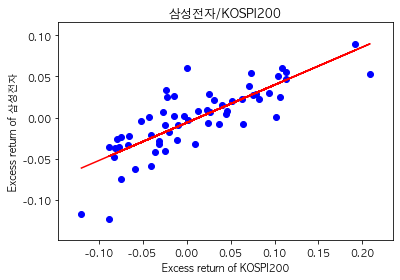

                            OLS Regression Results                            
Dep. Variable:               KOSPI200   R-squared:                       0.640
Model:                            OLS   Adj. R-squared:                  0.634
Method:                 Least Squares   F-statistic:                     103.1
Date:                Sat, 25 Apr 2020   Prob (F-statistic):           1.75e-14
Time:                        21:06:01   Log-Likelihood:                 138.05
No. Observations:                  60   AIC:                            -272.1
Df Residuals:                      58   BIC:                            -267.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.0051      0.003     -1.600      0.1

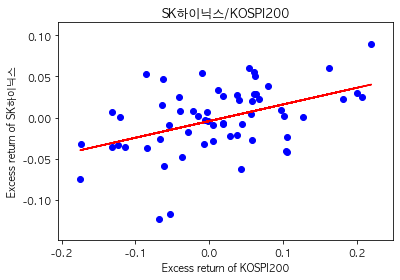

                            OLS Regression Results                            
Dep. Variable:               KOSPI200   R-squared:                       0.202
Model:                            OLS   Adj. R-squared:                  0.188
Method:                 Least Squares   F-statistic:                     14.68
Date:                Sat, 25 Apr 2020   Prob (F-statistic):           0.000315
Time:                        21:06:02   Log-Likelihood:                 114.17
No. Observations:                  60   AIC:                            -224.3
Df Residuals:                      58   BIC:                            -220.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.0032      0.005     -0.659      0.5

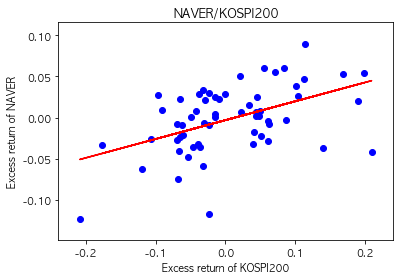

                            OLS Regression Results                            
Dep. Variable:               KOSPI200   R-squared:                       0.233
Model:                            OLS   Adj. R-squared:                  0.220
Method:                 Least Squares   F-statistic:                     17.66
Date:                Sat, 25 Apr 2020   Prob (F-statistic):           9.21e-05
Time:                        21:06:02   Log-Likelihood:                 115.37
No. Observations:                  60   AIC:                            -226.7
Df Residuals:                      58   BIC:                            -222.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.0020      0.005     -0.422      0.6

In [8]:
beta1, alpha1, r_squared1, residual_SD1 = regression_and_print_result(name1)
beta2, alpha2, r_squared2, residual_SD2 = regression_and_print_result(name2)
beta3, alpha3, r_squared3, residual_SD3 = regression_and_print_result(name3)

### b번 정답

In [54]:
print('%s\nbeta : %.3f\nalpha : %.3f\nr_squared : %.3f\nresidual_standard_deviation : %.3f\n' %(name1, beta1, alpha1, r_squared1, residual_SD1))
print('%s\nbeta : %.3f\nalpha : %.3f\nr_squared : %.3f\nresidual_standard_deviation : %.3f\n' %(name2, beta2, alpha2, r_squared2, residual_SD2))
print('%s\nbeta : %.3f\nalpha : %.3f\nr_squared : %.3f\nresidual_standard_deviation : %.3f\n' %(name3, beta3, alpha3, r_squared3, residual_SD3))

삼성전자
beta : 0.460
alpha : -0.006
r_squared : 0.641
residual_standard_deviation : 0.058

SK하이닉스
beta : 0.202
alpha : -0.004
r_squared : 0.203
residual_standard_deviation : 0.070

NAVER
beta : 0.229
alpha : -0.003
r_squared : 0.234
residual_standard_deviation : 0.067



### c번
#### index의 risk premium은 4%(= 0.04), standard deviation은 20%(= 0.2)
#### 임의로 정하는 alpha 값은 다음과 같음.

In [60]:
index_risk_premium = 0.04/12 # 문제 가정
index_standard_deviation = 0.2/math.sqrt(12) # 문제 가정
pred_alpha1 = 0.012 # 내가 정한 값
pred_alpha2 = 0.0105 # 내가 정한 값
pred_alpha3 = 0.001 # 내가 정한 값

### d번
### optimal risky portfolio를 구하라!

In [61]:
# passive - active(종목 A, B, C) 비율 전체 케이스 구하기. 
_range = list(range(0, 101))
range_all = [] #[M, A, B, C] -> M 는 market index 비율. A, B, C는 각 회사들의 비율
for i in range(-100, 100):
    for j in range(-100 , len(_range) - i):
        for k in range(-100 , len(_range) - i - j):
            range_all.append([i/100, j/100, k/100, (100-i-j-k)/100])

이하 3장 PPT 64 page 식들을 이용하였음.

In [62]:
# 전체 과정에서 optimal(maximize sharpe ratio)을 찾는 과정.
optimal_market_rate = 0
optimal_a_rate = 0
optimal_b_rate = 0
optimal_c_rate = 0
optimal_alpha = 0
optimal_beta = 0
optimal_expected_risk_premium = 0
optimal_sharpe_ratio = 0
optimal_residual_variance = 0
for i in range(len(range_all)):
    market_rate = range_all[i][0]
    a_rate = range_all[i][1]
    b_rate = range_all[i][2]
    c_rate = range_all[i][3]
    pf_alpha = a_rate*pred_alpha1 + b_rate*pred_alpha2 + c_rate*pred_alpha3
    pf_beta = a_rate*beta1 + b_rate*beta2 + c_rate*beta3 # 이 beta가 회귀선의 기울기 쓰면 되는건가..?
    pf_residual_variance = ((a_rate)**2)*(residual_SD1**2) + ((b_rate)**2)*(residual_SD2**2) + ((c_rate)**2)*(residual_SD3**2)
    pf_expected_risk_premium = pf_alpha + pf_beta*index_risk_premium
    pf_volatility = math.sqrt((pf_beta**2) * (index_standard_deviation**2) + pf_residual_variance)
    pf_sharpe_ratio = pf_expected_risk_premium/pf_volatility
    if(pf_sharpe_ratio > optimal_sharpe_ratio):
        optimal_market_rate = market_rate
        optimal_a_rate = a_rate
        optimal_b_rate = b_rate
        optimal_c_rate = c_rate
        optimal_alpha = pf_alpha
        optimal_beta = pf_beta
        optimal_residual_variance = pf_residual_variance
        optimal_expected_risk_premium = pf_expected_risk_premium
        optimal_sharpe_ratio = pf_sharpe_ratio

### d번 정답.

In [63]:
print("The optimal sharpe ratio is %.3f\nHere are the rates.\nmarket : %.2f\n%s: %.2f\n%s: %.2f\n%s: %.2f" %(optimal_sharpe_ratio, optimal_market_rate, name1, optimal_a_rate, name2, optimal_b_rate, name3, optimal_c_rate))

The optimal sharpe ratio is 0.256
Here are the rates.
market : -0.47
삼성전자: 0.89
SK하이닉스: 0.56
NAVER: 0.02


### e번. Information ratio 구하기. ( 3장 page 67 참고)

In [64]:
information_ratio = optimal_alpha/math.sqrt(optimal_residual_variance)

In [66]:
print("Information ratio : %.3f" %(information_ratio))

Information ratio : 0.256


### f번. sharpe ratio comparison (optimal vs index)

In [67]:
print('Optimal Sharpe Ratio is %.3f\nIndex Sharpe Ratio is %.3f' %(optimal_sharpe_ratio, index_risk_premium/index_standard_deviation))

Optimal Sharpe Ratio is 0.256
Index Sharpe Ratio is 0.058
